In [1]:
from radpy.stellar import *
from radpy.datareadandformat import *
from radpy.plotting import plot_v2_fit
from radpy.LDfitting import initial_LDfit, run_LDfit
from radpy.UDfitting import initial_UDfit, run_UDfit, udfit_values

In [2]:
filenamec = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\ClassicData.csv"
filenamep = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\PAVOdata.csv"
filenamev = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\Vegadata.csv"
filenamem = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\MIRCX_June11162025_HD_219134.oifits"
filenamemy = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\MYSTIC_June11162025_HD_219134.oifits"
#filenames = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\SPICA_01_2025-06-11T11-16-21_HD_219134_L2.fits"

In [3]:
datav, num_brack_v = filename_extension(filenamev, 'V')
datac, num_brack_c = filename_extension(filenamec, 'C')
datap, num_brack_p = filename_extension(filenamep, 'P')
datam, num_brack_m = filename_extension(filenamem, 'M')
#datas, num_brack_s = filename_extension(filenames, 'S')
datamy, num_brack_my = filename_extension(filenamemy, 'My')

Number of brackets: 20
Number of brackets: 1
Number of brackets: 17
Number of brackets: 36
Number of brackets: 62


In [4]:
pavo_data = PavoData(datap)
vega_data = VegaData(datav)
classic_data = ClassicData(datac)
mircx_data = MircxData(datam)
mystic_data = MysticData(datamy)
#spica_data = SpicaData(datas)

In [5]:
df_m = mircx_data.make_df()
df_my = mystic_data.make_df()
df_p = pavo_data.make_df()
df_v = vega_data.make_df()
df_c = classic_data.make_df()
#df_s = spica_data.make_df()

In [6]:
b, v2, dv2, wave, band, brack, inst = combined(df_p, df_c, df_v)
spf = b/wave

In [7]:
star = StellarParams()
p = 152.864
dp = 0.0494
f = 21.751
df = 0.585
logg = 4.5
dlogg = 0.1
m = 0.09
dm = 0.08

star.fbol = f
star.fbol_err = df
star.logg = logg
star.logg_err = dlogg
star.feh = m
star.feh_err = dm
star.plx = p
star.plx_err = dp

In [8]:
D, dD = distances('HD 219134', verbose = True)
star.dist = D
star.dist_err = dD

Found Gaia DR3 ID: Gaia DR3 2009481748875806976
Corrected parallax: 152.83842 [mas]
Distance: 6.54286 +/- 0.00212 [pc]


C:\Users\oxfor\anaconda3\lib\site-packages\zero_point\zpt.py:205: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  warnings.warn(


In [9]:
theta1, dtheta1, chisqr1, v01, dv01 = initial_UDfit(spf, v2, dv2, 0.4,1.0, star, v0_flag = False, verbose = True)


Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 461
    # variables        = 1
    chi-square         = 583.593270
    reduced chi-square = 1.26868102
    Akaike info crit   = 110.706678
    Bayesian info crit = 114.840076
    R-squared          = -60.2680353
[[Variables]]
    theta:  1.03756289 +/- 0.00128204 (0.12%) (init = 0.4)
    V0:     1 (fixed)


In [39]:
theta2, dtheta2, chisqr2, v02, dv02 = initial_LDfit(spf, v2, dv2, star, 'R', v0_flag = False, verbose = True)

Effective temperature: 4963.23239 +/- 33.51206 K
LDC for filter  R : 0.6672
Initial fit with lmfit:
[[Model]]
    Model(V2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 461
    # variables        = 1
    chi-square         = 578.043019
    reduced chi-square = 1.25661526
    Akaike info crit   = 106.301366
    Bayesian info crit = 110.434764
    R-squared          = -59.6853470
[[Variables]]
    theta:  1.11365607 +/- 0.00140433 (0.13%) (init = 1.03756)
    V0:     1 (fixed)


In [32]:
def UDV2(sf, theta, V0):
    x = np.pi*sf*(theta/(206265*1000))
    if V0 == 1:
        vis2 = (((2*ss.jv(1,x))/x)**2)
        return vis2
    else:
        vis2 = (V0**2)*(((2*ss.jv(1,x))/x)**2)
        return vis2

In [73]:
from radpy.UDfitting import *

def initial_UDfit(spf, v2, dv2, theta_guess, V0_guess, star_params, v0_flag=False, verbose=False):
    #####################################################################
    # Function: initial_UDfit                                           #
    # Inputs: spf -> spatial frequency                                  #
    #         v2 -> visibilitity squared                                #
    #         dv2 -> error on the V2                                    #
    #         theta_guess -> initial guess for theta                    #
    #         star_params -> stellar class object                       #
    #         v0_flag -> set to fit with a scaling factor or not        #
    #                    True: fits with a scaling factor               #
    #         verbose -> if set to True, allows print statements        #
    #                    defaults to False                              #
    # Outputs: theta_ilm -> initial uniform disk diameter               #
    #          dtheta_ilm -> error on the diameter                      #
    #          chisqr_ilm -> chi squared reduced value                  #
    # What it does:                                                     #
    #        1. Initialized the model                                   #
    #        2. initializes the parameters                              #
    #        3. If the v0_flag is not set, will fix V0 to be 1.0        #
    #        4. Fits for the UD diameter using lmfit                    #
    #           uses for the weights as 1/dv2                           #
    #        5. pulls out the theta, dtheta, and chi squared reduced    #
    #        6. updates the stellar object                              #
    #        7. Returns the theta, dtheta, and chi squared reduced      #
    #####################################################################

    udmodel = Model(UDV2)
    udparams = udmodel.make_params(theta=theta_guess, V0=V0_guess)
    if not v0_flag:
        # Fix V0 to 1.0 (or V0_guess, but default should be 1.0)
        udparams['V0'].set(value=1.0, vary=False)
    ud_result = udmodel.fit(v2, udparams, sf=spf, weights=1 / (dv2), scale_covar=False)
    # Extract parameters
    if v0_flag:
        theta_ilm, dtheta_ilm, v0_ilm, dv0_ilm = safe_param_extraction(ud_result)
    else:
        theta_ilm, dtheta_ilm, v0_ilm, dv0_ilm = safe_param_extraction(
            ud_result)  # extract, but v0_ilm will be 1.0, dv0_ilm may be 0
    chisqr_ilm = ud_result.redchi
    if verbose:
        print('Initial fit with lmfit:')
        print(ud_result.fit_report())
    star_params.update(
        udthetai=round(theta_ilm, 5),
        udthetai_err=round(dtheta_ilm, 5),
        udv0i=round(v0_ilm, 5),
        udv0i_err=round(dv0_ilm, 5)
    )
    return theta_ilm, dtheta_ilm, chisqr_ilm, v0_ilm, dv0_ilm

def udfit(df, stellar_params, v0_flag = False, verbose=False):
    #####################################################################
    # Function: udfit                                                   #
    # Inputs: df -> dataframe with data in it                           #
    #         star_params -> stellar class object                       #
    #         verbose -> if set to True, allows print statements        #
    #                    defaults to False                              #
    # Outputs: theta_ud -> initial uniform disk diameter                #
    # What it does:                                                     #
    #        1. Initialized the model                                   #
    #        2. initializes the parameters                              #
    #        3. Fits for the UD diameter using lmfit                    #
    #           uses for the weights as 1/dv2                           #
    #        4. pulls out the theta                                     #
    #        5. Returns the theta                                       #
    #####################################################################
    udmodel = Model(UDV2)
    ud_params = udmodel.make_params(theta=stellar_params.udthetai, V0 = stellar_params.udv0i)
    if not v0_flag:
        # Fix V0 to 1.0 (or V0_guess, but default should be 1.0)
        ud_params['V0'].set(value=1.0, vary=False)
    ud_result = udmodel.fit(df['V2'], ud_params, sf=df['Spf'], weights=1 / (df['dV2']), scale_covar=True)

    #theta_ud = ud_result.uvars['theta'].n
    if v0_flag:
        theta_ud = ud_result.uvars['theta'].n
        v0_ud = ud_result.uvars['V0'].n
        return theta_ud, v0_ud
    if not v0_flag:
        theta_ud = ud_result.uvars['theta'].n
        return theta_ud

def run_UDfit(mc_num, bs_num, datasets, stellar_params, v0_flag = False, verbose=False):
    ######################################################################
    # Function: run_udmcbs_fit                                           #
    # Inputs: mc_num -> number of Monte Carlo iterations                 #
    #         bs_num -> number of bootstrap iterations                   #
    #         datasets -> the datasets you want fit                      #
    #                     format: [inst1, inst2, inst3]                  #
    #         stellar_params -> star object                              #
    #         verbose -> if True, allows print statements                #
    #                    default is False                                #
    # Outputs: UD -> a list of all the uniform disk diameters calculated #
    #                during the fitting routine                          #
    # What it does:                                                      #
    #      1. Initializes the empty list for the diameters               #
    #      2. If verbose is set, it initializes the empty lists for      #
    #         spf, v2, and dv2                                           #
    #      3. enters the Monte Carlo loop                                #
    #      4. Creates the dataframes for each dataset                    #
    #      5. For each dataframe, samples the wavelength of observation  #
    #         on a normal distribution. Then calculates new spatial      #
    #         frequencies                                                #
    #      6. Enters the bootstrapping loop                              #
    #      7. Pulls the instrument for each data set                     #
    #      8. Calls the bootstrap function with the instrument's df and  #
    #         the instrument ID                                          #
    #      9. appends the output of the bootstrap function to a list.    #
    #     10. Concatenates all the dataframes created in the bootstrap   #
    #         loop.                                                      #
    #     11. Calculates the uniform disk diameter with udfit            #
    #     12. Appends the diameter to the list called UD.                #
    #     13. After the loops, returns the UD.                           #
    ######################################################################
    UD = []
    V0 = []
    if verbose:
        udmcbs_spf = []
        udmcbs_v2 = []
        udmcbs_dv2 = []

    for _ in range(mc_num):
        dfs = [d.make_df() for d in datasets]

        for df in dfs:
            df['Spf'] = df['B'] / np.random.normal(df['Wave'], df['Band'])

        for _ in range(bs_num):
            bs_dfs = []

            for df in dfs:
                inst = df["Instrument"].iloc[0]
                # print('Instrument:', inst)
                boot_df = bootstrap(df, inst)
                bs_dfs.append(boot_df)

            new_df = pd.concat(bs_dfs, ignore_index=True)

            if v0_flag:
                theta_udbs, v0_udbs = udfit(new_df, stellar_params, v0_flag, verbose)
                UD.append(theta_udbs)
                V0.append(v0_udbs)

            if not v0_flag:
                theta_udbs = udfit(new_df, stellar_params, v0_flag, verbose)
                UD.append(theta_udbs)
    
    if v0_flag:
        if verbose:
            udmcbs_spf.append(new_df['Spf'])
            udmcbs_v2.append(new_df['V2'])
            udmcbs_dv2.append(new_df['dV2'])
            return UD, V0, udmcbs_spf, udmcbs_v2, udmcbs_dv2
        return UD, V0
    if not v0_flag:
        if verbose:
            udmcbs_spf.append(new_df['Spf'])
            udmcbs_v2.append(new_df['V2'])
            udmcbs_dv2.append(new_df['dV2'])
            return UD, udmcbs_spf, udmcbs_v2, udmcbs_dv2
        return UD

def udfit_values(x, y, dy, UD, stellar_params, V0 = None, v0_flag = False, verbose=False):
    ################################################################
    # Function: udfit_values                                       #
    # Inputs: x -> the spatial frequencies                         #
    #         y -> the V2                                          #
    #        dy -> the error on the V2                             #
    #        UD -> the list of diameters                           #
    #        stellar_params -> the star object                     #
    #        verbose - > if true, returns print statements         #
    # Outputs: None                                                #
    # What it does:                                                #
    #     1. Takes the mean of the uniform disk diameter list      #
    #     2. Takes the median absolute deviation of the UDs        #
    #     3. Calculates the chi squared and chi squared reduced    #
    #        of the uniform disk diameter fit.                     #
    #     4. Calculates the effective temperature using the mean   #
    #     5. Updates the stellar object with the new parameters    #
    ################################################################
    avg_UD = np.mean(UD)
    std_UD = mad_std(UD)
    if v0_flag:
        avg_V0 = np.mean(V0)
        std_V0 = mad_std(V0)
        chisq, chisqr = chis(y, UDV2(x, avg_UD, avg_V0), y, 2)
        teff_ud = temp(stellar_params.fbol, stellar_params.fbol_err, avg_UD, std_UD)
        stellar_params.update(teff=round(teff_ud[0], 5), teff_err=round(teff_ud[1], 5), udtheta=round(avg_UD, 5),
                              udtheta_err=round(std_UD, 5), udv0=round(avg_V0, 5), udv0_err=round(std_V0, 5))
    if not v0_flag:
        chisq, chisqr = chis(y, UDV2(x, avg_UD, 1), y, 1)
        teff_ud = temp(stellar_params.fbol, stellar_params.fbol_err, avg_UD, std_UD)
        stellar_params.update(teff=round(teff_ud[0], 5), teff_err=round(teff_ud[1], 5), udtheta=round(avg_UD, 5),
                              udtheta_err=round(std_UD, 5))

    if verbose:
        print('Uniform Disk Diameter after MC/BS:', round(avg_UD, 4), '+/-', round(std_UD, 5), 'mas')
        if v0_flag:
            print('V0**2:', round(avg_V0, 4), '+/-', round(std_V0, 4))
        print("Chi-squared:", round(chisq, 3))
        print("Chi-squared reduced:", round(chisqr, 3))
        print("Temperature:", round(teff_ud[0], 1), "+/-", round(teff_ud[1], 1), "K")


In [74]:
theta1, dtheta1, chisqr1, v01, dv01 = initial_UDfit(spf, v2, dv2, 0.4,1.0, star, v0_flag = True, verbose = True)

Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 461
    # variables        = 2
    chi-square         = 583.416313
    reduced chi-square = 1.27105951
    Akaike info crit   = 112.566872
    Bayesian info crit = 120.833668
    R-squared          = -60.2494576
[[Variables]]
    theta:  1.03857987 +/- 0.00267297 (0.26%) (init = 0.4)
    V0:     1.00261510 +/- 0.00610421 (0.61%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(theta, V0) = +0.8778


In [82]:
theta_results = run_UDfit(5, 5, datasets = [pavo_data, vega_data, classic_data], 
                                      stellar_params = star, v0_flag = False)

In [86]:
len(theta_results)

1

In [85]:
udfit_values(spf, v2, dv2, theta_results, star, v0_flag = False, verbose = True)

Uniform Disk Diameter after MC/BS: 1.0376 +/- 0.0 mas
Chi-squared: 21.033
Chi-squared reduced: 0.046
Temperature: 4963.0 +/- 33.4 K


In [33]:
def V2(sf, theta, mu, V0):
    alpha = 1-mu
    beta = mu
    x = np.pi*sf*(theta/(206265*1000))
    if V0 == 1:
        vis = ((((alpha / 2) + (beta / 3)) ** (-2)) * ((alpha * (ss.jv(1, x) / x)) + beta * (
                    np.sqrt(np.pi / 2) * (ss.jv(3 / 2, x) / (x ** (3 / 2))))) ** 2)
        return vis
    else:
        vis = (V0**2)*((((alpha/2)+(beta/3))**(-2))*((alpha*(ss.jv(1,x)/x))+ beta*(np.sqrt(np.pi/2)*(ss.jv(3/2,x)/(x**(3/2)))))**2)
        return vis

In [40]:
from lmfit import Model
import scipy.special as ss

dummodel = Model(V2, independent_vars=['sf', 'mu'])
dumparams = dummodel.make_params(theta = 0.4, V0 = 1)
dumparams['V0'].set(value=1.0, vary=False)
dum_result = dummodel.fit(v2, dumparams, sf = spf, mu = 0.6672, weights = 1/(dv2), scale_covar = False)
print(dum_result.fit_report())

[[Model]]
    Model(V2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 461
    # variables        = 1
    chi-square         = 578.043009
    reduced chi-square = 1.25661524
    Akaike info crit   = 106.301358
    Bayesian info crit = 110.434756
    R-squared          = -59.6853459
[[Variables]]
    theta:  1.11365574 +/- 0.00140433 (0.13%) (init = 0.4)
    V0:     1 (fixed)


In [11]:
theta_results, v0_results = run_UDfit(71, 71, datasets = [pavo_data, vega_data, classic_data], 
                                      stellar_params = star, v0_flag = False)

In [12]:
udfit_values(spf, v2, dv2, theta_results, v0_results, stellar_params = star, verbose = True)

Uniform Disk Diameter after MC/BS: 1.0387 +/- 0.00431 mas
V0**2: 1.0 +/- 0.0
Chi-squared: 21.356
Chi-squared reduced: 0.046
Temperature: 4960.4 +/- 34.9 K


In [13]:
thetaf, dthetaf,v0_ld, dv0_ld, tf, dtf, ldcsf, chisf = run_LDfit(71, 71, ogdata = [spf, v2, dv2], 
                                                                 datasets = [pavo_data, vega_data, classic_data], 
                                                                 stellar_params = star, v0_flag = False, verbose = True)



Final Values after  2  iterations:
Limb-darkened Disk Diameter after MC/BS: 1.0549 +/- 0.05354 mas
V0^2: 1.0 +/- 0.0
Limb-darkening coefficient in R: 0.67116
Chi-squared for R band: 2782.876
Reduced chi-squared for R band: 6.05
Limb-darkening coefficient in K: 0.3147
Chi-squared for K band: 670.651
Reduced chi-squared for K band: 1.458
Temperature: 4922.3 +/- 129.2 K
Percent difference: 0.02 %
Percent difference: 0.05 %


In [14]:
calc_star_params(star, verbose = True)

Linear Radius:  0.743 +/- 0.038 [R_solar]
Luminosity:  0.291 +/- 0.008 [L_solar]
Effective temperature:  4922.318 +/- 129.225 [K]


In [15]:
data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data}
#data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data, 'mircx':mircx_data,'mystic':mystic_data}

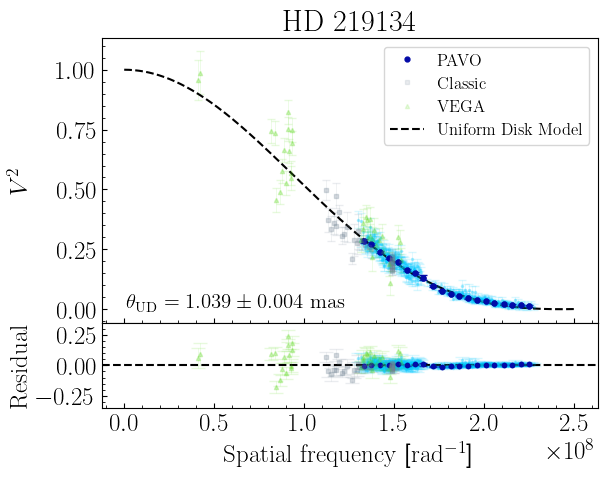

(<Figure size 640x480 with 2 Axes>,
 (<Axes: title={'center': '$\\rm HD~219134$'}, ylabel='$V^2$'>,
  <Axes: xlabel='$\\rm Spatial$ $\\rm frequency$ [$\\rm rad^{-1}$]', ylabel='$\\rm Residual$'>))

In [16]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,        
    datasets_to_plot=['pavo', 'classic', 'vega'],
    to_bin = ['pavo'],
    plot_udmodel = True,
    title = rf'$\rm HD~219134$',
    #set_axis= [-0.05, 5e8, -0.05, 1.1],
    eq_text=True,
    show = True
    )

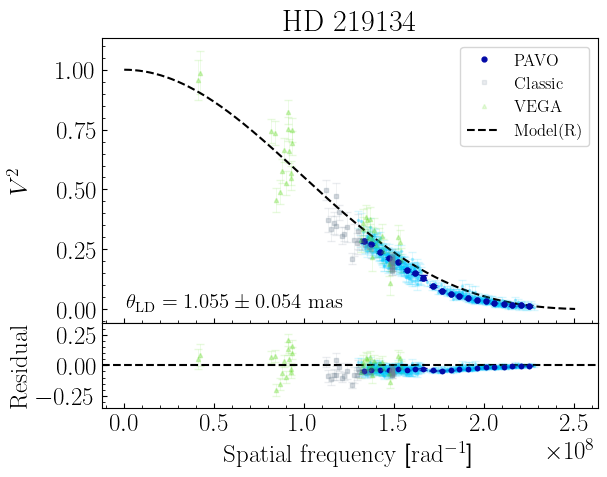

(<Figure size 640x480 with 2 Axes>,
 (<Axes: title={'center': '$\\rm HD~219134$'}, ylabel='$V^2$'>,
  <Axes: xlabel='$\\rm Spatial$ $\\rm frequency$ [$\\rm rad^{-1}$]', ylabel='$\\rm Residual$'>))

In [18]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,        
    datasets_to_plot=['pavo', 'classic', 'vega'],
    to_bin = [ 'pavo'],
    ldc_band = 'ldc_R',
    plot_ldmodel = True,
    title = rf'$\rm HD~219134$',
    #set_axis= [-0.05, 5e8, -0.05, 1.1],
    eq_text=True,
    show = True
    )

In [ ]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,        
    datasets_to_plot=['mircx'],
    plot_udmodel = True,
    title = rf'$\rm HD~219134$',
    #set_axis= [-0.05, 5e8, -0.05, 1.1],
    eq_text=True,
    show = True
    )

In [ ]:
datas

In [ ]:
ucoord = datas['UCOORD[m]']
vcoord = datas['VCOORD[m]']
v2 = datas['V2']
wave = datas['Eff_wave[m]']
import numpy as np
base = np.sqrt(ucoord**2 + vcoord**2)
spf = base/wave

In [ ]:
pip list

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.close()
plt.plot(df_m['B']/df_m['Wave'], df_m['V2'], '.', label = 'MIRCX')
plt.plot(df_p['B']/df_p['Wave'], df_p['V2'], '.', label = 'PAVO')
plt.plot(df_c['B']/df_c['Wave'], df_c['V2'], '.', label = 'Classic')
plt.plot(df_v['B']/df_v['Wave'], df_v['V2'], '.', label = 'VEGA')
plt.plot(df_s['B']/df_s['Wave'], df_s['V2'], '.', label = 'SPICA')
plt.legend()
plt.show()

In [ ]:
datas = oifits_to_pandas(filenames, 'S')

In [ ]:
ucoord = datas['UCOORD[m]']
vcoord = datas['VCOORD[m]']
v2 = datas['V2']
wave = datas['Eff_wave[m]']
import numpy as np
base = np.sqrt(ucoord**2 + vcoord**2)
spf = base/wave

In [ ]:
plt.plot(spf, v2, '.')